Начну работу с удаления строк с признаком Статус поиска = в процессе. Делается это так как такие данные не смогут достоверно описать нашу целевую переменную. Также удалю данные, которые напрямую связанны с таргетом (если они у нас будут, то простым вычетанием мы сможем определить таргет без каких либо более сложных алгоритмов)

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from tqdm import tqdm

import pandas as pd
import chardet
from io import BytesIO

# Определяем исходную кодировку файла
with open('data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

df = pd.read_csv('data.csv', encoding=encoding)

# Преобразуем DataFrame в Excel формат и загружаем в переменную `data`
excel_buffer = BytesIO()
df.to_excel(excel_buffer, index=False, engine='openpyxl')
excel_buffer.seek(0)
data = pd.read_excel(excel_buffer, engine='openpyxl')



data_filtered = data[data['Статус поиска'] != 'в процессе']

data_filtered = data_filtered.drop(columns=['Дата начала поиска', 'Дата окончания поиска'])

numeric_features = data_filtered.select_dtypes(include=['int64', 'float64'])
categorical_features = data_filtered.select_dtypes(include=['object'])

print("Числовые данные: " + str(numeric_features.shape[1]))
print("Категориальные данные: " + str(categorical_features.shape[1]))


Числовые данные: 29
Категориальные данные: 22


In [ ]:
Далее кодирую категориальные данные для удобства дальнейшего использования. 

In [2]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in categorical_features.columns:
    le = LabelEncoder()
    
    # Кодируем только непустые значения
    non_nan_values = categorical_features[column].dropna().astype(str)
    encoded_values = le.fit_transform(non_nan_values)
    
    
    categorical_features.loc[non_nan_values.index, column] = encoded_values
    label_encoders[column] = le

Заполняю данные с помощью случайного леса. Принято решение данные с пропусками не удалаять так как это негативно скажется на работе итоговой модели.
Случайный лес выбрал за его высокую точность, устойчивость к переобучению и эффективность для работы с неполными данными. Также он достаточно устойчив к выбросам.

In [3]:
combined_data = pd.concat([numeric_features, categorical_features], axis=1)

# Заполнение пропусков для числовых признаков с использованием RandomForestRegressor
for column in tqdm(combined_data.columns[combined_data.isna().any()], desc="Заполнение пропусков для данных"):
    data_no_nan = combined_data.dropna(subset=[column])   # строки без пропусков в текущем столбце
    data_nan = combined_data[combined_data[column].isna()] # строки с пропусками в текущем столбце

    if data_no_nan.empty or data_nan.empty:
        continue
    
    # Используем SimpleImputer для временного заполнения остальных пропусков
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(data_no_nan.drop(columns=[column]))
    y_train = data_no_nan[column]
    
    
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)
    
    
    X_test = imputer.transform(data_nan.drop(columns=[column]))
    predicted_values = model.predict(X_test)
    
    
    combined_data.loc[data_nan.index, column] = predicted_values

missing_data = combined_data.isna().sum()

print("Количество пропусков в каждом столбце:")
for column, count in missing_data.items():
    print(f"Столбец: {column}, Пропуски: {count}")

Заполнение пропусков для данных: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [16:10<00:00, 32.34s/it]

Количество пропусков в каждом столбце:
Столбец: Наименование расщелины, Пропуски: 0
Столбец: Количество труб, Пропуски: 0
Столбец: Количество дополнительных отвилков, Пропуски: 0
Столбец: Количество пилотных отвилков, Пропуски: 0
Столбец: Глубина по отвилку, Пропуски: 0
Столбец: Глубина первого отвилка, Пропуски: 0
Столбец: Путь поиска в первом отвилке, Пропуски: 0
Столбец: Общее время поиска, Пропуски: 0
Столбец: Общее время активного поиска, Пропуски: 0
Столбец: Общее время простоев, Пропуски: 0
Столбец: Количество аварий, Пропуски: 0
Столбец: Количество брака, Пропуски: 0
Столбец: Количество геологических осложнений, Пропуски: 0
Столбец: Количество осложнений, Пропуски: 0
Столбец: Количество простоев по метеоусловиям, Пропуски: 0
Столбец: Количество простоев, Пропуски: 0
Столбец: Количество ремонтов, Пропуски: 0
Столбец: Количество простоев без виновника, Пропуски: 0
Столбец: Количество простоев по вине королевства, Пропуски: 0
Столбец: Количество простоев в поиске, Пропуски: 0
Стол

In [4]:
print("\nСтатистика по данным после заполнения:")
for column in combined_data.columns:
    count_nan_after = combined_data[column].isna().sum()  # Количество пропусков в текущем столбце после заполнения
    total_count_after = len(combined_data)  # Общее количество элементов в столбце
    print(f"Столбец: {column: <20} | Пропуски: {count_nan_after: <5} | Всего элементов: {total_count_after}")



Статистика по данным после заполнения:
Столбец: Наименование расщелины | Пропуски: 0     | Всего элементов: 13251
Столбец: Количество труб      | Пропуски: 0     | Всего элементов: 13251
Столбец: Количество дополнительных отвилков | Пропуски: 0     | Всего элементов: 13251
Столбец: Количество пилотных отвилков | Пропуски: 0     | Всего элементов: 13251
Столбец: Глубина по отвилку   | Пропуски: 0     | Всего элементов: 13251
Столбец: Глубина первого отвилка | Пропуски: 0     | Всего элементов: 13251
Столбец: Путь поиска в первом отвилке | Пропуски: 0     | Всего элементов: 13251
Столбец: Общее время поиска   | Пропуски: 0     | Всего элементов: 13251
Столбец: Общее время активного поиска | Пропуски: 0     | Всего элементов: 13251
Столбец: Общее время простоев | Пропуски: 0     | Всего элементов: 13251
Столбец: Количество аварий    | Пропуски: 0     | Всего элементов: 13251
Столбец: Количество брака     | Пропуски: 0     | Всего элементов: 13251
Столбец: Количество геологических осложне

In [5]:
target_column = 'Общее время поиска' 
target = combined_data[target_column]
combined_data = combined_data.drop(columns=[target_column])


Далее проверил кореляционную зависимость таргета от данных. Зависимость есть, следовательно дальнейшая работа имеет смысл. Такой анализ также может помочь для выявление аспектов, которые наиболее сильно влияют на время завершения работы. Так что на контроле за ними следует сфокусировать внимание и силы. Стоит отметить, что такие фичи как количество каких либо проблем. простоев и так далее я оставляю в модели при предположении о том, что существуют и применяются какие то методы для их прогнозирования до завершения разработки месторождения. 

In [6]:
sampled_data = combined_data.sample(frac=1, random_state=42)

sampled_data[target_column] = target

# Вычисление корреляции признаков с целевой переменной
correlation_matrix = sampled_data.corr()

# Сортировка корреляций по абсолютному значению и выбор топ-15
top_15_corr = correlation_matrix[target_column].abs().sort_values(ascending=False).head(15)

print(top_15_corr)

Общее время поиска                        1.000000
Общее время простоев                      0.732415
Общее время активного поиска              0.641334
Количество простоев в поиске              0.536562
Количество ремонтов                       0.524705
Количество простоев                       0.486908
Общий путь поиска                         0.338157
Количество брака                          0.330255
Глубина по отвилку                        0.305046
Количество простоев в наклонном поиске    0.273992
Тип расщелины                             0.255093
Количество простоев без виновника         0.230956
Количество пилотных отвилков              0.230919
Количество аварий                         0.216914
Количество осложнений                     0.216653
Name: Общее время поиска, dtype: float64


Тепловая карта показала, что черезмерной кореляции между данными не присутствует. Исходя из этого принято решение не прибегать к методам уменьшения размерности. 

C:\Users\nbagr\AppData\Local\Temp\ipykernel_20384\1671991486.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25_data[target_column] = sampled_data[target_column]


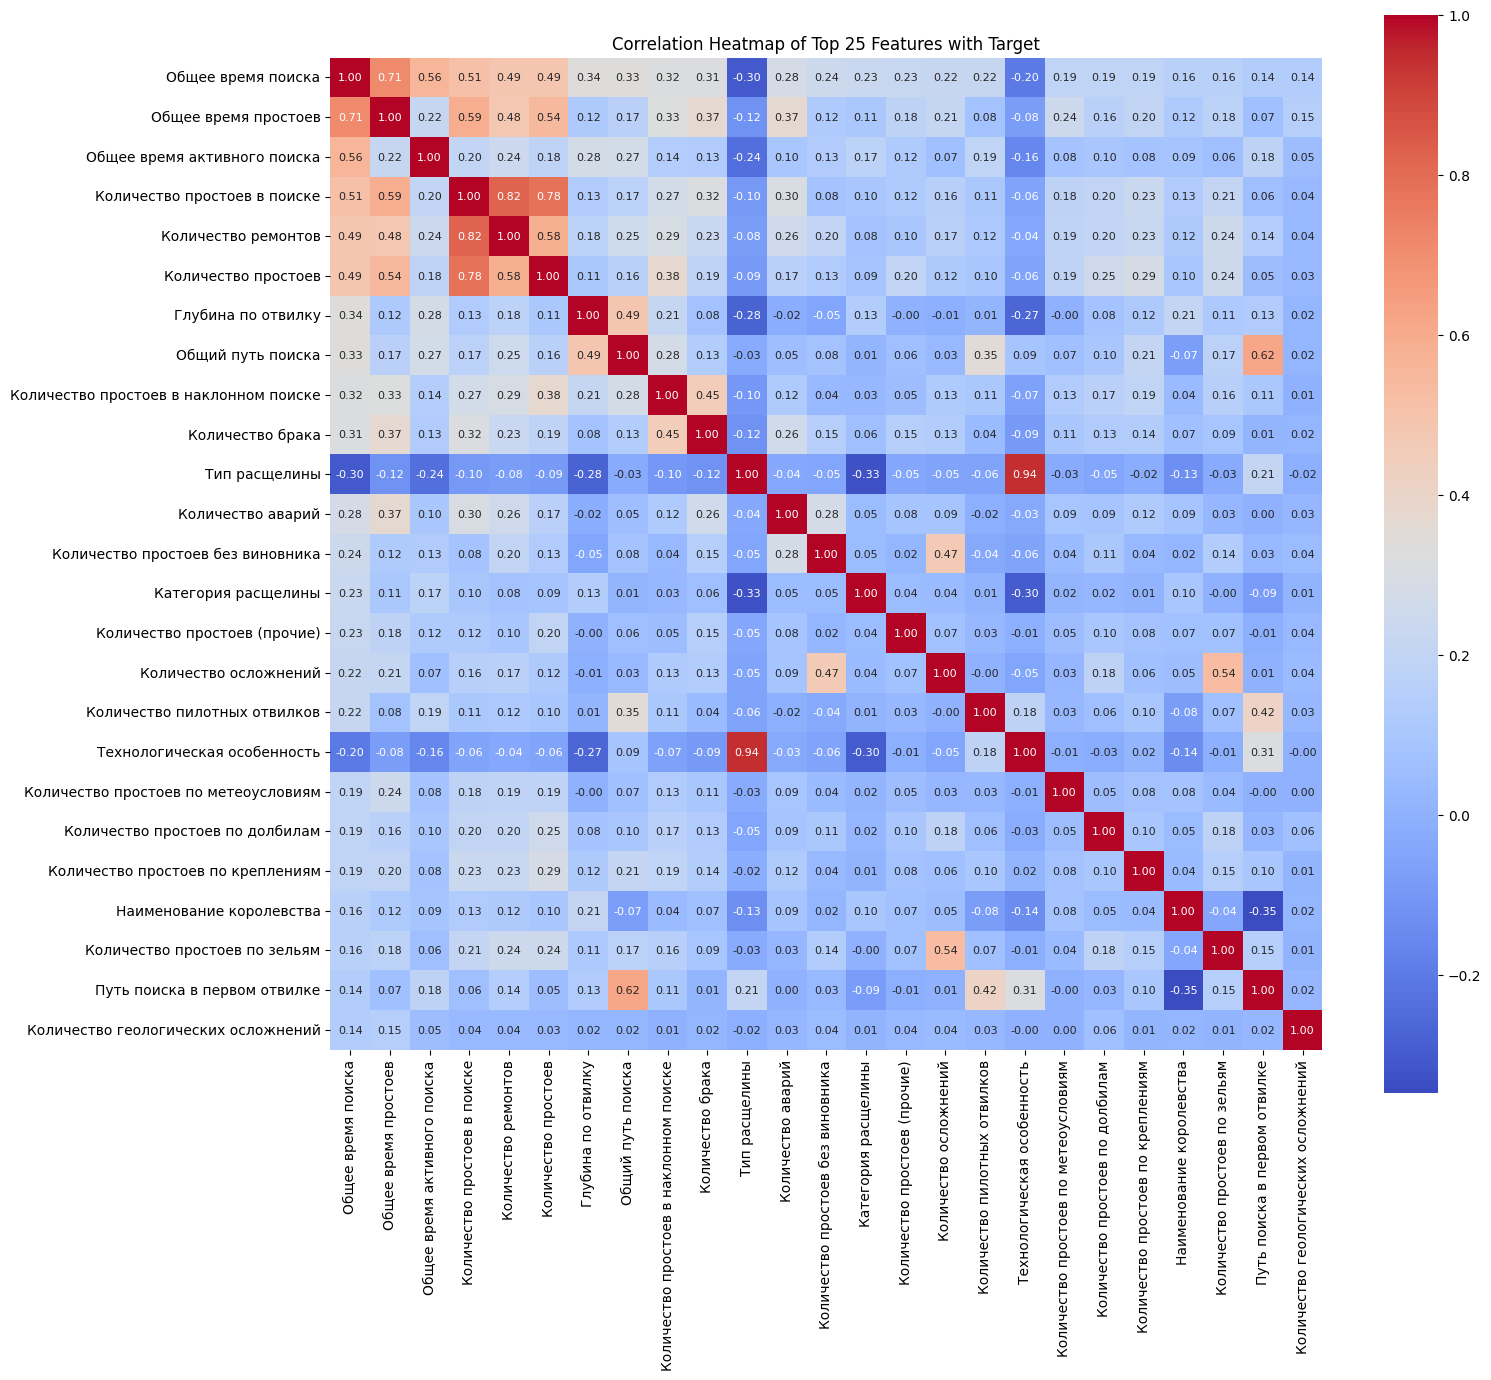

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sampled_data = combined_data.sample(frac=0.3, random_state=42)
sampled_data[target_column] = target
correlation_matrix = sampled_data.corr()
top_25_corr = correlation_matrix[target_column].abs().sort_values(ascending=False).head(25)
top_25_features = top_25_corr.index.tolist()
top_25_data = sampled_data[top_25_features]
top_25_data[target_column] = sampled_data[target_column]
corr_matrix_top_25 = top_25_data.corr()

plt.figure(figsize=(16, 14))

# Строим тепловую карту корреляций для топ-25 признаков
sns.heatmap(corr_matrix_top_25, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True,
            annot_kws={"size": 8},  # Уменьшаем размер шрифта аннотаций
            xticklabels=corr_matrix_top_25.columns,  # Подписи на оси X
            yticklabels=corr_matrix_top_25.columns)  # Подписи на оси Y

plt.xticks(rotation=90) 
plt.yticks(rotation=0) 


plt.title("Correlation Heatmap of Top 25 Features with Target")
plt.show()

Принято решение добавить составные данные в датасет. Эти данные помогают моделям более тчоно прогнозировать таргет. 

In [8]:
import pandas as pd
import numpy as np

# 1. Total Downtime — Сумма всех типов простоев
downtime_columns = [
    'Количество простоев',
    'Количество простоев по метеоусловиям',
    'Количество простоев по вине королевства',
    'Количество простоев в поиске',
    'Количество простоев в наклонном поиске',
    'Количество простоев по зельям',
    'Количество простоев в контроле поиска',
    'Количество простоев в конце расщелины',
    'Количество простоев по долбилам',
    'Количество простоев по вине исследователей',
    'Количество простоев по креплениям',
    'Количество простоев (прочие)'
]
combined_data['Total Downtime'] = combined_data[downtime_columns].sum(axis=1)

# 2. Total Issues — Сумма аварий и брака
combined_data['Total Issues'] = combined_data[['Количество аварий', 'Количество брака']].sum(axis=1)

# 3. Total Helpers — Сумма всех помощников
helper_columns = [
    'Помощник по контролю поиска', 'Помощник по поиску', 'Помощник по наклонным расщелинам',
    'Помощник по зельям', 'Помощник по долбилам', 'Помощник по исследованиям',
    'Помощник по укреплению', 'Помощник по огненным заклятиям', 'Помощник по подвескам', 'Помощник по вырезке окна'
]
combined_data['Total Helpers'] = combined_data[helper_columns].sum(axis=1)

# 4. Geographic Info — Комбинированная информация о местоположении
combined_data['Geographic Info'] = combined_data[['Наименование королевства', 'Наименование земли', 'Наименование хребта']].sum(axis=1)

# 5. Total Path Length — Сумма всех путей поиска
combined_data['Total Path Length'] = combined_data[['Общий путь поиска', 'Путь поиска в первом отвилке']].sum(axis=1)

# 6. Type and Purpose — Комбинированный тип и назначение расщелины
combined_data['Type and Purpose'] = combined_data[['Тип расщелины', 'Назначение расщелины']].sum(axis=1)




Выбросы в данных забыты не были. Были предприняты попытки создания некоторых критериев по которым данные можно было считать выбросами, но удаление этих данных пагубно сказалось на метриках моделей. 

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

target_copy = target.copy()

scaler = StandardScaler()

data_normalized = scaler.fit_transform(combined_data)

data_normalized_df = pd.DataFrame(data_normalized, columns=combined_data.columns)

Модель случайного леса

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(data_normalized_df, target_copy, test_size=0.2, random_state=7)

# Создание и настройка модели случайного леса
rf_model = RandomForestRegressor(random_state=7, n_estimators=500)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf_optimized = mean_absolute_error(y_test, y_pred_rf)
mse_rf_optimized = mean_squared_error(y_test, y_pred_rf)
r2_rf_optimized = r2_score(y_test, y_pred_rf)

print(f"Случайный лес - MAE: {mae_rf_optimized:.4f}, MSE: {mse_rf_optimized:.4f}, R²: {r2_rf_optimized:.4f}")


Случайный лес - MAE: 1.6989, MSE: 32.2198, R²: 0.9053


In [ ]:
Модель градиентного бустинга

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(data_normalized_df, target_copy, test_size=0.2, random_state=42)

gb_model = GradientBoostingRegressor(n_estimators=1000, random_state=7, verbose=1)

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Градиентный бустинг - MAE: {mae_gb:.4f}, MSE: {mse_gb:.4f}, R²: {r2_gb:.4f}")


      Iter       Train Loss   Remaining Time 
         1         306.7181            1.38m
         2         265.4228            1.37m
         3         229.6240            1.39m
         4         201.3206            1.38m
         5         176.6495            1.36m
         6         155.3757            1.37m
         7         137.6710            1.36m
         8         122.8314            1.35m
         9         110.3444            1.35m
        10          99.7599            1.35m
        20          48.6805            1.36m
        30          32.7243            1.33m
        40          26.0446            1.30m
        50          22.6402            1.29m
        60          20.5829            1.28m
        70          19.4216            1.27m
        80          18.0870            1.24m
        90          17.0162            1.22m
       100          16.3668            1.20m
       200          11.5962            1.05m
       300           9.0331           54.77s
       40

Модель экстремального градиентного бустинга

In [17]:
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll import scope
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0)
}

def objective(params):
    params['n_estimators'] = int(params['n_estimators']) 
    params['max_depth'] = int(params['max_depth'])
    
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # Прогнозируем и вычисляем ошибку
    y_pred = model.predict(X_test)
    
    # Возвращаем MSE для оптимизации
    return mean_squared_error(y_test, y_pred)

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])

print("Best parameters:", best)

best_model = xgb.XGBRegressor(**best, random_state=7)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Экстремальный Градиентный бустинг - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.64s/trial, best loss: 25.63073008652002]
Best parameters: {'colsample_bytree': 0.7646131773556749, 'learning_rate': 0.1719705053977594, 'max_depth': 7, 'n_estimators': 872, 'subsample': 0.9314437949191332}
Экстремальный Градиентный бустинг - MAE: 1.7729, MSE: 25.6307, R²: 0.9091


По MSE и R² оптимальной оказалась модель модель экстремального градиентного бустинга  MSE: 25.6307, R²: 0.9091 (best_model), по MAE же лучшей стала модель случайного леса MAE: 1.6989 (rf_model)